# GPT-Q

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pennylane import numpy as np

torch.set_printoptions(precision=3)

In [4]:
from models import QConv1d

ks = 5  # kind of arbitrary, limited by the number of available qubits
p = (ks - 1) // 2

qconv = QConv1d(kernel_size=ks, out_channels=3, n_qlayers=1, stride=1, padding=p)
qconv.draw()

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


 0: ──RX(0)──RX(2.55)───╭C──────────────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(5.12)───╰X──╭C──────────│───┤ ⟨Z⟩ 
 2: ──RX(0)──RX(0.797)──────╰X──╭C──────│───┤ ⟨Z⟩ 
 3: ──RX(0)──RX(5.5)────────────╰X──╭C──│───┤     
 4: ──RX(0)──RX(4.72)───────────────╰X──╰C──┤     



In [56]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.310, 0.500, 0.655, 0.777, 0.563, 0.625, 0.045, 0.495],
         [0.071, 0.888, 0.020, 0.053, 0.069, 0.692, 0.083, 0.517],
         [0.164, 0.454, 0.252, 0.570, 0.795, 0.342, 0.162, 0.544],
         [0.562, 0.461, 0.636, 0.300, 0.554, 0.463, 0.585, 0.177]]])


In [57]:
z = qconv(x)
print(z.shape)

torch.Size([1, 4, 8, 3])


In [58]:
z[:, :, :, 0].shape

torch.Size([1, 4, 8])

In [59]:
zc = z.view((1, 4, embed_dim*3))
print(zc.shape)

torch.Size([1, 4, 24])


1 + (c*w + 2*p - k) / s = w
=> (c*w - k) / s = w - 1
=> s = (c*w - k) / (w - 1)
this has to be an integer.

n = (c*w - k) / (w - 1) => n * (w - 1) = c*w - k => k = c*w - n * (w - 1)
k = (3 - n) * w + n, 0 < k < 3*w

In [60]:
def find_k(w, c):
    for n in range(10):
        # n = (b*w - k) / (d - 1) => n * (d - 1) = b*w - k => k = b*w - n*w + n
        k = c*w - n * (w - 1)
        if k < 0:
            break
        print(k)

find_k(embed_dim, 4)

32
25
18
11
4


In [61]:
ks_inv = 3
stride_inv = (3 * embed_dim - ks_inv) // (embed_dim - 1)
print(f"kernel size (=no. of qubits): {ks_inv}")
print(f"stride: {stride_inv}")
qconv_inv = QConv1d(kernel_size=ks_inv, out_channels=1, n_qlayers=1, stride=stride_inv, padding=0)
qconv_inv.draw()

kernel size (=no. of qubits): 3
stride: 3
 0: ──RX(0)──RX(0.386)──╭C──────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(5.78)───╰X──╭C──│───┤     
 2: ──RX(0)──RX(0.339)──────╰X──╰C──┤     



In [62]:
y = qconv_inv(zc).view((batch_size, seq_len, -1))
print(y.shape)

torch.Size([1, 4, 8])


In [63]:
x = torch.arange(24).view(1, 2, 4, 3)
print(x)

tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8],
          [ 9, 10, 11]],

         [[12, 13, 14],
          [15, 16, 17],
          [18, 19, 20],
          [21, 22, 23]]]])


In [64]:
x = x.transpose(-1,-2).view(1,2,3,-1)
print(x)
x = x.reshape((1,2,12))
print(x)


tensor([[[[ 0,  3,  6,  9],
          [ 1,  4,  7, 10],
          [ 2,  5,  8, 11]],

         [[12, 15, 18, 21],
          [13, 16, 19, 22],
          [14, 17, 20, 23]]]])
tensor([[[ 0,  3,  6,  9,  1,  4,  7, 10,  2,  5,  8, 11],
         [12, 15, 18, 21, 13, 16, 19, 22, 14, 17, 20, 23]]])


In [65]:
print(zc)
zc.transpose(-1, -2)

tensor([[[ 2.837e-02,  9.960e-01, -3.804e-01,  6.729e-02,  9.375e-01,
          -5.154e-01,  4.412e-03,  8.373e-01, -5.624e-01,  2.919e-02,
           7.044e-01, -5.332e-01, -1.181e-01,  5.778e-01, -3.474e-01,
          -2.614e-02,  6.345e-01, -4.119e-01, -3.615e-02,  7.000e-01,
          -8.884e-02, -2.691e-01,  8.537e-01, -4.654e-01],
         [-2.798e-02,  9.960e-01, -1.521e-01, -3.674e-01,  9.908e-01,
          -8.172e-01, -2.644e-02,  6.025e-01, -6.152e-02,  1.809e-02,
           6.916e-01, -9.328e-02, -3.616e-02,  9.941e-01, -1.496e-01,
          -1.908e-02,  9.940e-01, -6.946e-01, -4.321e-02,  7.465e-01,
          -1.226e-01, -2.772e-01,  8.142e-01, -4.589e-01],
         [-5.107e-02,  9.960e-01, -2.425e-01,  9.954e-03,  9.767e-01,
          -4.985e-01,  4.539e-02,  8.794e-01, -2.882e-01, -5.328e-02,
           8.934e-01, -5.421e-01, -1.886e-01,  8.099e-01, -6.228e-01,
          -7.285e-04,  5.951e-01, -2.446e-01, -7.682e-02,  7.031e-01,
          -1.699e-01, -2.843e-01,  9.476e-

tensor([[[ 2.837e-02, -2.798e-02, -5.107e-02,  3.846e-02],
         [ 9.960e-01,  9.960e-01,  9.960e-01,  9.960e-01],
         [-3.804e-01, -1.521e-01, -2.425e-01, -5.977e-01],
         [ 6.729e-02, -3.674e-01,  9.954e-03, -6.114e-02],
         [ 9.375e-01,  9.908e-01,  9.767e-01,  8.237e-01],
         [-5.154e-01, -8.172e-01, -4.985e-01, -4.256e-01],
         [ 4.412e-03, -2.644e-02,  4.539e-02,  3.345e-03],
         [ 8.373e-01,  6.025e-01,  8.794e-01,  7.798e-01],
         [-5.624e-01, -6.152e-02, -2.882e-01, -5.130e-01],
         [ 2.919e-02,  1.809e-02, -5.328e-02, -1.575e-02],
         [ 7.044e-01,  6.916e-01,  8.934e-01,  7.269e-01],
         [-5.332e-01, -9.328e-02, -5.421e-01, -2.707e-01],
         [-1.181e-01, -3.616e-02, -1.886e-01,  1.525e-02],
         [ 5.778e-01,  9.941e-01,  8.099e-01,  8.030e-01],
         [-3.474e-01, -1.496e-01, -6.228e-01, -4.767e-01],
         [-2.614e-02, -1.908e-02, -7.285e-04, -9.751e-02],
         [ 6.345e-01,  9.940e-01,  5.951e-01,  8.114e-01

### vectorize input to CNN

In [4]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.361, 0.553, 0.733, 0.886, 0.842, 0.999, 0.695, 0.516],
         [0.103, 0.035, 0.632, 0.898, 0.592, 0.010, 0.843, 0.252],
         [0.948, 0.475, 0.857, 0.788, 0.344, 0.803, 0.183, 0.217],
         [0.851, 0.826, 0.503, 0.877, 0.742, 0.920, 0.205, 0.533]]])


In [7]:
stride = 2
kernel_size = 3
padding = 0

In [8]:
from torch.nn import functional as F

out_dim = int((embed_dim + 2 * padding - kernel_size) / stride) + 1
z = F.pad(x, (padding, padding), "constant", 0)
print(z.shape)
print(f"out_dim: {out_dim}\n")
for i in range(batch_size):
    for j in range(seq_len):
        for k in range(0, out_dim):
            k_start = k*stride
            k_end = k_start + kernel_size
            z_slice  = z[i, j, k_start:k_end]
            print(z_slice)
        print('---')

torch.Size([1, 4, 8])
out_dim: 3

tensor([0.361, 0.553, 0.733])
tensor([0.733, 0.886, 0.842])
tensor([0.842, 0.999, 0.695])
---
tensor([0.103, 0.035, 0.632])
tensor([0.632, 0.898, 0.592])
tensor([0.592, 0.010, 0.843])
---
tensor([0.948, 0.475, 0.857])
tensor([0.857, 0.788, 0.344])
tensor([0.344, 0.803, 0.183])
---
tensor([0.851, 0.826, 0.503])
tensor([0.503, 0.877, 0.742])
tensor([0.742, 0.920, 0.205])
---


In [9]:
idx = np.arange(0, kernel_size)
x[:,:,idx]

tensor([[[0.361, 0.553, 0.733],
         [0.103, 0.035, 0.632],
         [0.948, 0.475, 0.857],
         [0.851, 0.826, 0.503]]])

In [10]:
idx = np.expand_dims(np.arange(kernel_size), 0) + np.expand_dims(np.arange(out_dim) * stride, 0).T
print(idx)

[[0 1 2]
 [2 3 4]
 [4 5 6]]


In [11]:
x[:,:,idx]

tensor([[[[0.361, 0.553, 0.733],
          [0.733, 0.886, 0.842],
          [0.842, 0.999, 0.695]],

         [[0.103, 0.035, 0.632],
          [0.632, 0.898, 0.592],
          [0.592, 0.010, 0.843]],

         [[0.948, 0.475, 0.857],
          [0.857, 0.788, 0.344],
          [0.344, 0.803, 0.183]],

         [[0.851, 0.826, 0.503],
          [0.503, 0.877, 0.742],
          [0.742, 0.920, 0.205]]]])

In [88]:
from models import QConv1d

qconv = QConv1d(kernel_size, stride=stride, padding=padding)

In [89]:
out = qconv(x)
print(out.shape)
print(out)

torch.Size([1, 4, 6, 3])
tensor([[[[0.973, 0.808, 0.797],
          [0.919, 0.795, 0.746],
          [0.976, 0.968, 0.945],
          [0.830, 0.752, 0.750],
          [0.890, 0.896, 0.883],
          [0.958, 0.980, 0.958]],

         [[0.973, 0.987, 0.964],
          [0.902, 0.918, 0.838],
          [0.990, 0.953, 0.945],
          [0.964, 0.848, 0.842],
          [0.799, 0.861, 0.780],
          [0.802, 0.997, 0.802]],

         [[0.744, 0.995, 0.740],
          [0.839, 0.841, 0.753],
          [0.995, 0.680, 0.679],
          [0.911, 0.782, 0.778],
          [0.958, 0.965, 0.957],
          [0.872, 0.860, 0.855]],

         [[0.973, 0.766, 0.763],
          [0.710, 0.749, 0.554],
          [0.903, 0.919, 0.889],
          [0.810, 0.673, 0.549],
          [0.963, 0.913, 0.906],
          [0.698, 0.670, 0.532]]]], grad_fn=<StackBackward>)


## FeedForward

In [5]:
from models import FeedForwardQuantum

embed_dim = 8
n_qubits = 5
n_qlayers = 1
boom_factor = 4
ff = FeedForwardQuantum(embed_dim, boom_factor=boom_factor, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [6]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))

print("input:", x.shape)
xff = ff.forward(x)
print("output:", xff.shape)

input: torch.Size([1, 4, 8])
output: torch.Size([1, 4, 8])


## Attention

In [9]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.964, 0.776, 0.797, 0.132, 0.005, 0.225, 0.763, 0.818],
         [0.998, 0.020, 0.987, 0.329, 0.430, 0.608, 0.548, 0.698],
         [0.829, 0.442, 0.601, 0.259, 0.688, 0.809, 0.910, 0.808],
         [0.446, 0.084, 0.925, 0.620, 0.958, 0.173, 0.355, 0.116]]])


In [7]:
from models import MultiHeadAttentionQuantum

n_heads = 2
n_qubits = 5
n_qlayers = 1
n_heads = 4

attn = MultiHeadAttentionQuantum(embed_dim, n_heads, n_qubits, n_qlayers)

In [8]:
out = attn(x)
print("output of attention:", out.shape)

output of attention: torch.Size([1, 4, 8])


## Transformer block

In [9]:
from models import TransformerBlockQuantum

transformer = TransformerBlockQuantum(embed_dim, n_heads=n_heads, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [10]:
x_tf = transformer.forward(x)
print("transformer block output:", x_tf.shape)

transformer block output: torch.Size([1, 4, 8])


## GPT-2 Model

In [59]:
from models import GPT2

embed_dim = 8
batch_size = 1
max_seq_len = 16
src_vocab = 8
tgt_vocab = 4 
n_tlayers = 2
n_heads = 4

gpt2 = GPT2(embed_dim=embed_dim,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            n_heads=n_heads,
            n_tlayers=n_tlayers,
            max_seq_len=max_seq_len)

In [60]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[7, 5, 3, 7, 3, 7, 1, 7, 6, 4, 4, 2, 4, 4, 4, 6]])


In [61]:
%timeit out = gpt2(token_ids)
print("GPT-2 output:", out.shape)

2.39 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
GPT-2 output: torch.Size([1, 16, 4])


## GPT-Q Model

In [62]:
from models import GPTQ

n_qlayers = 1
q_device = "default.qubit"

gptq = GPTQ(embed_dim=embed_dim,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            n_heads=n_heads,
            n_tlayers=n_tlayers,
            max_seq_len=max_seq_len,
            n_qlayers=n_qlayers,
            q_device=q_device)

[autoreload of models failed: Traceback (most recent call last):
  File "/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/IPython/extensions/autor

In [63]:
%timeit out = gptq(token_ids)
print("GPT-Q output:", out.shape)

3.99 s ± 404 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPT-Q output: torch.Size([1, 16, 4])


In [64]:
gptq.attn_mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## Masks

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

from utils import make_padding_mask, make_subsequent_mask, make_lookahead_mask

In [119]:
batch_size = 2
max_seq_len = 4
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[5, 4, 2, 7],
        [6, 7, 5, 2]])


In [120]:
make_padding_mask(token_ids)

tensor([[[True, True, True, True]],

        [[True, True, True, True]]])

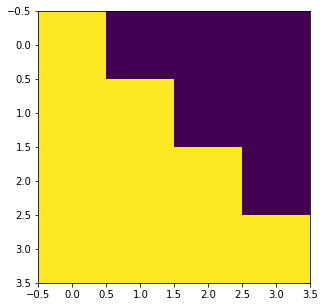

In [121]:
plt.figure(figsize=(5,5))
plt.imshow(make_subsequent_mask(max_seq_len)[0])

In [139]:
from utils import make_lookahead_mask, make_src_mask


token_ids = np.array([
    [1, 2, 3, 0, 0],
    [1, 2, 3, 4, 0]
], dtype=np.int32)
token_ids = torch.from_numpy(token_ids)

print(token_ids)
print(make_src_mask(token_ids.size(1)))

tensor([[1, 2, 3, 0, 0],
        [1, 2, 3, 4, 0]], dtype=torch.int32)
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


## Train Classifier

In [26]:
from torchtext.datasets import IMDB

In [27]:
train_iter, test_iter = IMDB(split=('train', 'test'))

In [28]:
len(train_iter), len(test_iter)

(25000, 25000)

In [29]:
train_data = []
for label, line in train_iter:
    train_data.append(line)
print(train_data[:2])

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [48]:
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers

vocab_size = 300
min_frequency = 2
special_tokens = [
        "<s>",
        "<pad>",
        "</s>",
        "<unk>",
        "<mask>",
    ]

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    min_frequency=min_frequency,
    special_tokens=special_tokens)

tokenizer.train_from_iterator(train_data, trainer=trainer)
tokenizer.save("gptq.json")

In [49]:
tokenizer.encode("Hello world").ids

[225, 44, 73, 287, 83, 268, 282, 80, 72]

## Fit IMDb Sentiment Analysis Model

In [78]:
from dataset import IMDbDataModule

BATCH_SIZE = 4
max_seq_len = 16
n_examples_max = 16
#n_examples_max = 8 # for quick tests
#n_examples_max = None

dm = IMDbDataModule(val_split=0.2,
                    batch_size=BATCH_SIZE,
                    max_seq_length=max_seq_len,
                    n_examples_max=n_examples_max)

In [ ]:
from pytorch_lightning import Trainer

AVAIL_GPUS = min(1, torch.cuda.device_count())

trainer = Trainer(
    max_epochs=10,
    gpus=AVAIL_GPUS,
    log_every_n_steps=2,
    progress_bar_refresh_rate=20)

In [81]:
from models import GPT2, IMDbClassifier

embed_dim = 8
vocab_size = 2000
n_tlayers = 1
n_heads = 2
lr = 1e-3

classifier = IMDbClassifier(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_tlayers=n_tlayers,
                       max_seq_len=max_seq_len)

In [82]:
trainer.fit(classifier, dm)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.core.lightning:
  | Name    | Type       | Params
---------------------------------------
0 | wte     | Embedding  | 16.0 K
1 | wpe     | Embedding  | 128   
2 | dropout | Dropout    | 0     
3 | ln_f    | LayerNorm  | 16    
4 | h       | ModuleList | 872   
5 | out     | Linear     | 16    
---------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [83]:
torch.save(classifier.state_dict(), "imdb_classifier.pt")

In [84]:
%load_ext tensorboard

In [85]:
%tensorboard --logdir ./lightning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## IMBd Classifier Quantum

In [90]:
from models import GPTQ, IMDbClassifierQuantum

n_qlayers = 1
q_device = 'qulacs.simulator'

classifier_quantum = IMDbClassifierQuantum(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_tlayers=n_tlayers,
                       max_seq_len=max_seq_len,
                       q_device=q_device)

In [91]:
trainer.fit(classifier_quantum, dm)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.core.lightning:
  | Name    | Type       | Params
---------------------------------------
0 | wte     | Embedding  | 16.0 K
1 | wpe     | Embedding  | 128   
2 | dropout | Dropout    | 0     
3 | ln_f    | LayerNorm  | 16    
4 | h       | ModuleList | 51    
5 | out     | Linear     | 16    
---------------------------------------
16.2 K    Trainable params
0         Non-trainable params
16.2 K    Total params
0.065     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [92]:
torch.save(classifier_quantum.state_dict(), "imdb_classifier_quantum.pt")

In [ ]:
%tensorboard --logdir ./lightning_logs

## Fit Language Model

In [190]:
from models import LanguageModel

In [191]:
vocab_size = 2000
max_seq_len = 64
n_layers = 1
n_heads = 2
lr = 1e-3

model = LanguageModel(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_layers=n_layers,
                       max_seq_len=max_seq_len)